# One-particle entanglement for one dimensional spinless fermions after an interaction quantum quench

Matthias Thamm, Harini Radhakrishnan, Hatem Barghathi, Bernd Rosenow, and Adrian Del Maestro

We consider numerical resutls  for the J-V model
$$
H = -J \sum_{i=1}^L (c_i^\dagger c_{i+1} + c_{i+1}^\dagger c_i) + V(t)\sum_{i=1}^L n_i n_{i+1}\ ,
$$
at half filling $L= 2N$ in the Luttinger-Liquid (LL) phase $-2\leq V/J\leq 2$, with corresponding LL model
$$
H = \sum_{q} \left[\omega_0(q)+m(q,t)\right] b_q^\dagger(t) b_q(t) + \frac{1}{2} \sum_{q} g_2(q,t) \left(b_q(t) b_{-q}(t)+b_q^\dagger(t) b_{-q}^\dagger(t)\right)  \ .
$$ 

All plots used in the paper can be generated from this notebook. 
The other notebook `LL_numerical_calculations.ipynb` includes numerical integrations and fits for the LL results that are saved to the data folder and loaded here. To reproduce these calculations as well, run the notebook `LL_numerical_calculations.ipynb` before producing the plots using this notebook. Other data is generated using the ED and DMRG code linked in the README file.

### 0. Import packages and setup environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from scipy.optimize import OptimizeResult
from pathlib import Path
from numpy import pi as π 
from tqdm import tqdm 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import load_data_utils  
import LL_utils, analyze_data_utils
import colors as colortools

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/sf.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize'] 

style_file = plot_style['aps']

### Figure 1: Interaction dependence of one particle von Neumann entanglement entropies

Main panel: Load data for finite size scaling for inset

In [2]:
dV = 0.05
V_array = np.arange(-2.0, 2.0+dV/2, dV)
N_array_ED = np.arange(2, 17.5, 1)
nVs = np.shape(V_array)[0]

Sα_ED = np.zeros((np.size(V_array), 11, np.size(N_array_ED)))
# ED results N=2-16
idV = 5
nFermions_array = np.array(range(2, 16+1))
dat_path_template = "../data/eq_ED/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-2.000_Vend+2.000_Vstp+0.010.dat"
replace_list = [dict(M=2*n, N=n) for n in nFermions_array]
_, _, S_ld = load_data_utils.load_entanglement_from_files(
    dat_path_template, replace_list)
Sα_ED[:, :, :np.size(nFermions_array)] = S_ld[::idV, :, :np.shape(S_ld)[2]]
# ED results N=17-19
nFermions_array = np.array([17, 19])
dat_path_template = "../data/eq_ED/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-2.000_Vend+2.000_Vstp+0.050.dat"
replace_list = [dict(M=2*n, N=n) for n in nFermions_array]
_, V_ld, S_ld = load_data_utils.load_entanglement_from_files(
    dat_path_template, replace_list)
indV = np.argsort(V_ld[:, 0])
Sα_ED[:, :, -np.size(nFermions_array):] = S_ld[indV, :, :]


N_array_DMRG = np.concatenate([np.arange(17, 26, 1), [30, 40, 50]])
Sα_DMRG = np.zeros((np.size(V_array), 11, np.size(N_array_DMRG)))
# DMRG results N=17-25,30,40,50
nFermions_array_1 = np.concatenate([np.arange(17, 26, 1), [30, 40, 50]])
dat_path_template = "../data/eq_DMRG/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-2.000_Vend+2.000_Vnum0081.dat"
replace_list = [dict(M=2*n, N=n) for n in nFermions_array_1]
_, V_ld, S_ld = load_data_utils.load_entanglement_from_files(
    dat_path_template, replace_list)
indV = np.argsort(V_ld[:, 0])
Sα_DMRG[:, :, :np.size(nFermions_array_1)] = S_ld[indV, :, :]

N_all = np.concatenate(
    [N_array_ED, N_array_DMRG[N_array_DMRG > np.max(N_array_ED)]], axis=-1)
S_all = np.concatenate(
    [Sα_ED[:, :, :], Sα_DMRG[:, :, N_array_DMRG > np.max(N_array_ED)]], axis=-1)

Sinf = np.zeros((np.shape(S_all)[0], 11))
for i, ia in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0.5]):
    Sinf[:, i] = analyze_data_utils.interpolate_entropy_tdlimit(
        S_all, N_all, iα=ia, fit_npoints=10, V_array=V_array)

Main panel: Load DMRG $N=51$ equilibrium data for main panel

In [3]:
N_dmrg = 51 
dat_path_template = Path("../data/eq_DMRG/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-10.000_Vend+10.000_Vnum0201.dat").__str__()
 
replace_list = [dict(M=2*N_dmrg,N=N_dmrg)]
params_dmrg, V_dmrg_51, Sα_dmrg_51 = load_data_utils.load_entanglement_from_files(dat_path_template, replace_list)  

Main panel: Load LL equilibrium results

In [4]:
α = 1
ϵ = 0.84
filename = f'../data/eq_LL/entropiesLL_a{α}_LL_tdlimit_eps{ϵ}.npz' 
LL_fixed_eps = np.load(filename)

Inset: quench, Finite size scaling using ED and DMRG

In [ ]:
#ED
data_folder = "../data/quench_ED/"

V_array_quench = np.arange(-1.9,1.95,0.1)
N_array_EDquench = np.arange(2,13,1)

i_N = lambda n: n-N_array_EDquench[0]

# load
quench_N = []
for N in N_array_EDquench:
    quench_N.append(load_data_utils.load_quench_data(N,V_array_quench, folder=data_folder))
# estimate t->inf limit
for n in N_array_EDquench:
    quench_N[i_N(n)] = analyze_data_utils.estimate_tinf_limit_all(quench_N[i_N(n)],n)
# estimate TD limit
V_quench, Sinf_quench, Serr_quench = analyze_data_utils.estimate_tinf_tdlimit_all(quench_N,N_array_EDquench,fit_npoints=5)


dmrg_data_N_lookup =  {0.2: [11,12,13,14,15], -0.2: [13,14], 0.9: [11,12,13,14,15], -0.9: [12,13,14], 1.3: [13,14], 1.7: [13,14] , -1.3:[12,13], -1.7: [13]}

for i in range(1,12):
    for v in dmrg_data_N_lookup.keys():
        # ED Data
        N_array_fit = N_array_EDquench
        SinfN_fit = np.array([quench("S",i=i,t=[-1],V=v)[0] for quench in quench_N]) 
        SerrN_fit = np.array([quench("Serr",i=i,V=v) for quench in quench_N]) 
        iv = np.where(np.abs(V_quench-v)<1e-8)[0][0]
        # DMRG Data
        for nn in dmrg_data_N_lookup[v]:
            quench_DMRG = load_data_utils.load_itensor_quench_data(nn,tend=40,tstep=0.01,Vsta=v,Vend=v,Vnum=1,folder="../data/quench_dmrg") 
            quench_DMRG  = analyze_data_utils.estimate_tinf_limit_all(quench_DMRG ,nn) 
            if not nn in N_array_fit:
                    N_array_fit = np.concatenate([N_array_fit,[nn]])
                    SinfN_fit  = np.concatenate([SinfN_fit,[quench_DMRG("S",i=i,t=[-1],V=v)[0]]])
                    SerrN_fit = np.concatenate([SerrN_fit,[quench_DMRG("Serr",i=i,V=v)]])
        a, S_tdlimit, S_tdlimit_err = analyze_data_utils.fit_tail_linear(1/N_array_fit,SinfN_fit,npoints=6,std_err=SerrN_fit)

        Sinf_quench[i-1,[iv]] = S_tdlimit
        Serr_quench[i-1,[iv]] = S_tdlimit_err

Inset: quench, ED result for $N=12$

In [ ]:
data_folder = "../data/quench_ED/"

V_array_quench = np.arange(-1.9,1.95,0.1)
N_array_EDquench = np.arange(2,13,1)

i_N = lambda n: n-N_array_EDquench[0]

N = 12
quench_12 = load_data_utils.load_quench_data(N,V_array_quench, folder=data_folder)
# estimate t->inf limit 
quench_12 = analyze_data_utils.estimate_tinf_limit_all(quench_12,N) 

Inset: Load LL quench steady state results

In [7]:
α = 1
ϵ = 0.84
filename = f'../data/quench_LL/entropiesLL_quench_a{α}_LL_tdlimit_eps{ϵ}.npz' 
LL_quench_fixed_eps = np.load(filename)

Plot DMRG data and LL results

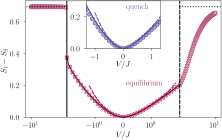

In [8]:
# parameters
ias = [0]
ia = 0
α = 1
colors = colortools.get_linear_colors('Spectral',2*len(ias),reverse=False) 

# create figure
fig, ax = plt.subplots() 

########################################################################################################
#### main panel
########################################################################################################
# main panel crosses: DMRG data N=51 equilibrium
for i,col in zip(ias,colors):
    props_DMRG = {'ls':'None','ms':4, 'marker':"X", "color": colortools.get_alpha_hex(col,0.7),
             'mfc':colortools.get_alpha_hex(col,0.3),"zorder":1,'mew':0.6}
    ax.plot(V_dmrg_51[:,0],Sα_dmrg_51[:,i,0],**props_DMRG, label="eq. DMRG")

# main panel solid line: td limit from ED and DMRG
props_tdl = {'ls':'None','ms':4,'ls': '-', "color": "#7c033a", "zorder":2}  
ax.plot(V_array,Sinf[:,ia],**props_tdl) 

# main panel dashed line: LL fixed cutoff
props_LL = {'ls':'None','ms':4,'ls': '--', "color": col,"zorder":3} 
vs = np.array(LL_fixed_eps['V'])
As = np.array(LL_fixed_eps['A'])
lim_d = -1.2
lim_u = 1.9
ax.plot(vs[(vs<=lim_u) & (lim_d<=vs)],As[(vs<=lim_u) & (lim_d<=vs)],**props_LL) 

# parameter for main panel
ax.plot([2,2],[-1,1],'k--')
ax.plot([-2,-2],[-1,1],'k-') 
ax.plot([-20,-2],[np.log(2),np.log(2)],'k--',dashes=(0.2, 2.5))
ax.plot([2,20],[np.log(2),np.log(2)],'k--',dashes=(0.2, 2.5))
ax.set_xscale('symlog')
ax.set_ylim([-0.00,0.73])
ax.set_xlim([-13,13])
ax.set_ylabel("$S_{1}-S_{\\rm ff}$") 
ax.set_xlabel("$V/J$") 
ax.text(0.1,0.2,"equilibrium",color=col) 

########################################################################################################
#### inset: ED fs scaling after quench
########################################################################################################

col = colors[1] 
in_ax = inset_axes(ax, width="38%", height="41%", loc='upper center', borderpad=0,
                       axes_kwargs=dict(fc='white'))  # x_start , y_start , height , width

# inset dots: ED N=12 quench t-> inf data
props_ED = {'ls':'None','ms':4,'marker':"o", "color": col,
            'mec':col,'mew':0.6, 'ecolor':col, 'elinewidth':1.0,
            'mfc':colortools.get_alpha_hex(col,0.5),"zorder":1} 
in_ax.errorbar(quench_12.V, quench_12.S[ia,-1,:], quench_12.Serr[ia,:],**props_ED, label="quench numerical") 
# inset solid line: td estimate for t->inf from ED and DMRG
props_tdl = {'ls':'None','ms':4,'ls': '-', "color": col,
            'mfc':colortools.get_alpha_hex(col,0.5),"zorder":2} 
in_ax.plot(V_quench, Sinf_quench[ia,:],**props_tdl)  
# inset dashed line: LL steady state fixed cutoff
props_LL = {'ls':'None','ms':4,'ls': '--', "color": col,"zorder":3 } 
vs = np.array(LL_quench_fixed_eps['V'])
As = np.array(LL_quench_fixed_eps['A'])
lim_d = -1.0
lim_u = 1.5
in_ax.plot(vs[(vs<=lim_u) & (lim_d<=vs)],As[(vs<=lim_u) & (lim_d<=vs)],**props_LL) 



# parameter for main inset
xlim = 1.315

in_ax.set_xlim(-xlim,xlim)
in_ax.set_ylim(0,0.3)
in_ax.set_yticks([0,0.2]) 
in_ax.set_xlabel("$V/J$",labelpad=0)
in_ax.text(0.1,0.25,"quench",color=col) 

# save 
figname = '001_particleEntropy_overview' 
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 2: Waiting time dependence of eigenvalues of one body density after quench

Load obdm data

In [5]:
V = -0.5
 
Ndata=[12]
N=Ndata[0]

L=2*N
obdm=np.zeros([L, 1001])
obdminv=np.zeros([1001,L ])

colors= colortools.get_linear_colors('Spectral',int(N/2),reverse=True)  
colors = np.concatenate([colors,list(reversed(colors)),colors,list(reversed(colors))])

FileName= f'../data/obdm/obdm_{L:02d}_{N:02d}_{V:+4.3f}_+0.000_tstart+0.000_tend+100.000_tstep+0.100.dat'

data = np.loadtxt(FileName)
index = data[0,1]
obdmED = data[:,1]
obdm[0:N+1,:]=data[N-1::,1:]
obdm[N+1::,:]=(-1)**(N % 2-1)*data[0:N-1,1:]


Construct from saved row

In [6]:
v = LL_utils.vV(V)
t=np.zeros(1001)
for ti in range(0,1001):
    t[ti]=ti*.1
    λ=np.zeros(L)
    if (N % 2==1):
        for q in range(0,N):
            for i in range(0,L):
                λ[N-1-q]+=obdm[i,ti]*np.cos((q+(1-N % 2)/2)*i*np.pi*2/L)
            if (0<q<N):
                λ[N+q-1]=λ[N-1-q]
        for i in range(0,L):
            λ[L-1]+=obdm[i,ti]*np.cos((N+(1-N % 2)/2)*i*np.pi*2/L)
    else:
        for q in range(0,N):
            for i in range(0,L):
                λ[N-1-q]+=obdm[i,ti]*np.cos((q+(1-N % 2)/2)*i*np.pi*2/L)
            λ[N+q]=λ[N-1-q]
    obdm[:,ti]=λ[:] 

Plot obdm

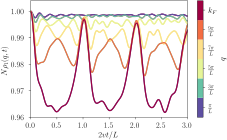

In [7]:
fig, ax = plt.subplots()

nPlot = 6
colors =  colortools.get_linear_colors("Spectral",nPlot,reverse=True) 
for i in range(L):
    t1=0
    t2=400
    ax.set_xlabel('$2vt/L$')
    ax.set_ylabel('$N\\rho_1(q,t)$')
    ax.plot(2*t[t1:t2]*v/L,N*obdm[i,t1:t2],'-',c = colors[i%nPlot], linewidth = 1.2,label=r'$Cyc_{\rm{tot}}(L,L)^{-1}$')
ax.set_xlim([0,3.0])
ax.set_ylim(0.96,1.004) 
 

cmap = mpl.colors.ListedColormap(colors[::], name='cols')
  

norm = mpl.colors.Normalize(vmin=0,vmax=np.pi)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax = plt.colorbar(sm, ticks=np.linspace(0,np.pi,nPlot), 
             boundaries=np.arange(0,np.pi+0.1,np.pi/6))

cax.set_ticks([2*np.pi*n/12 - np.pi/12+0.01 for n in range(1,7)],
    labels=["$\\frac{\pi}{\\bar{L}}$","$\\frac{3\pi}{\\bar{L}}$","$\\frac{5\pi}{\\bar{L}}$","$\\frac{7\pi}{\\bar{L}}$","$\\frac{9\pi}{\\bar{L}}$","$k_F$"]) 

cax.set_label("$q$")

figname = '002_obdmspectrum_overview' 
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 3: Distribution function after quantum quench

load data

In [39]:
V = [-6.5]
Vnum = len(V)
N = 12
L = 2*N
obdm = np.zeros([Vnum, L, 1001])


for Vi in range(Vnum):
    if V[Vi] >= 0:
        Vname = '+'+f'{V[Vi]:5.3f}'
    else:
        Vname = f'{V[Vi]:5.3f}'
    FileName = f'../data/obdm/obdms_N{N:02d}/obdm_{L:02d}_{N:02d}_' + \
        Vname+'_+0.000_tstart+0.000_tend+100.000_tstep+0.100.dat'
    data = np.loadtxt(FileName)
    """
    Adjust the data such that it represents the first raw of the obdm
    and takes into account the proper boundary conditions    
    """
    obdm[Vi, 0:N+1, :] = data[N-1::, 1:]
    obdm[Vi, N+1::, :] = (-1)**(N % 2-1)*data[0:N-1, 1:]

# time
t = [93.5, 27.6]
tnum = len(t)
λt = np.zeros([Vnum, L, tnum])
for Vi in range(Vnum):
    obdm[Vi, :, :] = analyze_data_utils.obdbs(obdm[Vi, :, :], N, L)
for tt in range(tnum):
    ti = int(t[tt]*10)
    λt[0, :, tt] = obdm[0, :, ti]
# q values
q = np.zeros(L)
for qi in range(0, L):
    q[qi] = (qi-N+(1-N % 2)/2)*2*π/L


plot

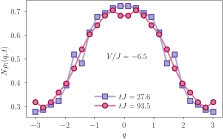

In [44]:
colors = colortools.get_linear_colors('Spectral',2)

fig, ax = plt.subplots()
ax.set_xlabel('$q$')
ax.set_ylabel('$N\\rho_1(q,t)$')
col = colors[1]
ax.plot(q, λt[0, :, 1]*N, '-s', color=colortools.get_alpha_hex(col,0.5),  
    markerfacecolor=colortools.get_alpha_hex(col,0.5), 
    lw=1.5, markeredgecolor=col, label=f' $tJ= {t[1]:4.1f}$')
col = colors[0]    
ax.plot(q, λt[0, :, 0]*N, '-o', color=colortools.get_alpha_hex(col,0.5), 
    markerfacecolor=colortools.get_alpha_hex(col,0.5), 
    lw=1.5, markeredgecolor=col, label=f' $tJ={t[0]:4.1f}$')


plt.text(-0.60, 0.5, f'$V/J={V[Vi]:5.1f}$')


lgnd1 = plt.legend(loc=(0.03, 0.65), handlelength=0.0,
                   title=None, frameon=False, handletextpad=.1)

ax.legend(handletextpad=0.5)

figname = "003_time_dependent_obdmf"
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg', dpi=400)


### Figure 4: Distribution function from LL result

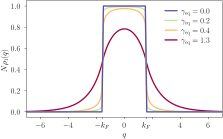

In [9]:
_Vs = [-1.9,1.9,1.0,0.0]

colors =  colortools.get_linear_colors('Spectral',len(_Vs),reverse=False) 

fig, ax = plt.subplots() 
ϵ = 0.84
qs = np.arange(-10,10,0.1)
for col,v in zip(colors,_Vs):
    γ = LL_utils.γeq_V(v)
    ax.plot(qs , [np.pi*LL_utils.fq_inf(q*ϵ,γ,ϵ) for q in qs], label = f"$\gamma_{{\\rm eq}}={γ:.1f}$",color=col,lw=1.3)
 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], handlelength=1.5 ) 
ax.set_xlabel("$q$")
ax.set_ylabel("$N\\rho_1(q)$") 
ax.set_xticks([-10,-8,-6,-4,-2,-np.pi/2,0,np.pi/2,2,4,6,8,10])
ax.set_xticklabels(["$-10$","$-8$","$-6$","$-4$","","$-k_F$","$0$","$k_F$","","$4$","$6$","$8$","$10$"])
ax.set_xlim(-7,7)

figname = '004_LL_analytic_fqInf'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 5: Equilibrium one-particle entanglement entropy and phases of J-V model from DMRG results

Load data

In [10]:
dV = 0.05
V_array = np.arange(-2.0, 2.0+dV/2, dV)
N_array_ED = np.arange(2, 17.5, 1)
nVs = np.shape(V_array)[0]

Sα_ED = np.zeros((np.size(V_array), 11, np.size(N_array_ED)))
# ED results N=2-16
idV = 5
nFermions_array = np.array(range(2, 16+1))
dat_path_template = "../data/eq_ED/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-2.000_Vend+2.000_Vstp+0.010.dat"
replace_list = [dict(M=2*n, N=n) for n in nFermions_array]
_, _, S_ld = load_data_utils.load_entanglement_from_files(
    dat_path_template, replace_list)
Sα_ED[:, :, :np.size(nFermions_array)] = S_ld[::idV, :, :np.shape(S_ld)[2]]
# ED results N=17-19
nFermions_array = np.array([17, 19])
dat_path_template = "../data/eq_ED/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-2.000_Vend+2.000_Vstp+0.050.dat"
replace_list = [dict(M=2*n, N=n) for n in nFermions_array]
_, V_ld, S_ld = load_data_utils.load_entanglement_from_files(
    dat_path_template, replace_list)
indV = np.argsort(V_ld[:, 0])
Sα_ED[:, :, -np.size(nFermions_array):] = S_ld[indV, :, :]


N_array_DMRG = np.concatenate([np.arange(17, 26, 1), [30, 40, 50]])
Sα_DMRG = np.zeros((np.size(V_array), 11, np.size(N_array_DMRG)))
# DMRG results N=17-25,30,40,50
nFermions_array_1 = np.concatenate([np.arange(17, 26, 1), [30, 40, 50]])
dat_path_template = "../data/eq_DMRG/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-2.000_Vend+2.000_Vnum0081.dat"
replace_list = [dict(M=2*n, N=n) for n in nFermions_array_1]
_, V_ld, S_ld = load_data_utils.load_entanglement_from_files(
    dat_path_template, replace_list)
indV = np.argsort(V_ld[:, 0])
Sα_DMRG[:, :, :np.size(nFermions_array_1)] = S_ld[indV, :, :]

N_all = np.concatenate(
    [N_array_ED, N_array_DMRG[N_array_DMRG > np.max(N_array_ED)]], axis=-1)
S_all = np.concatenate(
    [Sα_ED[:, :, :], Sα_DMRG[:, :, N_array_DMRG > np.max(N_array_ED)]], axis=-1)

Sinf = np.zeros((np.shape(S_all)[0], 11))
for i, ia in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0.5]):
    Sinf[:, i] = analyze_data_utils.interpolate_entropy_tdlimit(
        S_all, N_all, iα=ia, fit_npoints=10, V_array=V_array)

Sinf_ED = np.zeros((np.shape(S_all)[0],11))
for i,ia in enumerate([1,2,3,4,5,6,7,8,9,10,0.5]): 
    Sinf_ED[:,i] = analyze_data_utils.interpolate_entropy_tdlimit(Sα_ED, N_array_ED, iα = ia, fit_npoints= 10)

Plot data

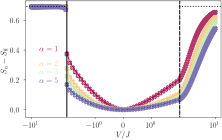

In [11]:
# load dmrg
N_dmrg = 51 
dat_path_template = Path("C:/Users/mtham/Dropbox/Dokumente/Universität/Skripte/PhD Thesis/Material/TN_Project/GitHub/DelMaestroGroup/tVparticleEEdmrg_julia/tVparticleEEdmrg/out/particle_entanglement_n01_M{M:02d}_N{N:02d}_t+1.000_Vp+0.000_Vsta-10.000_Vend+10.000_Vnum0201.dat").__str__()
 
replace_list = [dict(M=2*N_dmrg,N=N_dmrg)]
params_dmrg, V_dmrg, Sα_dmrg = load_data_utils.load_entanglement_from_files(dat_path_template, [dict(M=2*N_dmrg,N=N_dmrg)])  

# plot both
fig, ax = plt.subplots() 
ias = [0,1,2,4]

colors = colortools.get_linear_colors('Spectral',len(ias),reverse=False) 
for i,col in zip(ias,colors):
    props_DMRG = {'ls':'None','ms':4, 'marker':"X", "color": colortools.get_alpha_hex(col,0.8),
             'mfc':'none'}
    ax.plot(V_dmrg[:,0],Sα_dmrg[:,i,0],**props_DMRG,label=f"dmrg: $N={N_dmrg}, \\alpha={i+1 if i!=10 else 0.5}$")
    ax.plot(V_array,Sinf_ED[:,i],'--',color=col)
    ax.text(-7,Sinf_ED[0,i],f"$\\alpha={i+1 if i!=10 else 0.5}$",color=col)
ax.plot([2,2],[-1,1],'k--')
ax.plot([-2,-2],[-1,1],'k-')
ax.plot([-20,-2],[np.log(2),np.log(2)],'k--',dashes=(0.2, 2.5))
ax.plot([2,20],[np.log(2),np.log(2)],'k--',dashes=(0.2, 2.5))
ax.set_ylabel("$S_{\\rm \\alpha}-S_{\\rm ff}$")
ax.set_xlabel("$V/J$")
ax.set_xscale('symlog')
ax.set_ylim([-0.05,0.73])
ax.set_xlim([-13,13]) 
 
figname = f'005_stabilized_DMRG_eq_N51' 
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 6: Finite size scaling of equilibrium one-particle entanglement entropy

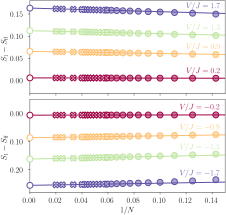

In [12]:
dV = 0.05
V_array = np.arange(-2.0, 2.0+dV/2, dV)

Vs = [0.2,0.9,1.3,1.7]
Vinds = [np.argmin(np.abs(V_array-v)) for v in Vs]

#fig, axs = plt.subplots(1,2)
fig, axs = plt.subplots(2,1,figsize=(3.4039, 1.65*2.10373))
ax_f = axs.flatten()
colors = colortools.get_linear_colors('Spectral',len(Vs),reverse=False) 

ax = ax_f[0]
for col,v, vind in zip(colors,Vs,Vinds):
    γ = LL_utils.γeq_V(v)

    # ED
    props_ED = {'ls':'None','ms':6,'marker':"o", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} #  'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0,
    ax.plot(1/N_array_ED,Sα_ED[vind,0,:],**props_ED)
    # DMRG
    props_DMRG = {'ls':'None','ms':6, 'marker':"X", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.2)}
    ax.plot(1/N_array_DMRG,Sα_DMRG[vind,0,:],**props_DMRG)
    
    # perform fit a*x+Sinf
    N_all = np.concatenate([N_array_ED,N_array_DMRG[N_array_DMRG > np.max(N_array_ED)]])
    S_all = np.concatenate([Sα_ED[vind,0,:],Sα_DMRG[vind,0,N_array_DMRG > np.max(N_array_ED)]])
    a, S_tdlimit = analyze_data_utils.fit_tail_linear(1/N_all,S_all,npoints=10)
    # plot fit
    x = np.arange(0,1,0.01)
    f = a*x+S_tdlimit
    ax.plot(x,f,color=col)
    ax.plot([0],[S_tdlimit],marker="o",**{ 'mfc': "white",'ls':'None','ms':6,"zorder":10,'color':col},clip_on=False)

    ax.text(0.12,Sα_ED[vind,0,-10]+0.0115,f"$V/J={v:1.1f}$",color=col)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.2f}"))
ax.set_ylim(-0.03,0.18)
ax.set_xlim(0,0.15) 
ax.set_ylabel("$S_1-S_{\\rm ff}$") 
ax.set_xticklabels("") 


# negative V

ax = ax_f[1]

Vs = [-0.2,-0.9,-1.3,-1.7]
Vinds = [np.argmin(np.abs(V_array-v)) for v in Vs] 
colors = colortools.get_linear_colors('Spectral',len(Vs),reverse=False) 


for col,v, vind in zip(colors,Vs,Vinds):
    γ = LL_utils.γeq_V(v)

    # ED
    props_ED = {'ls':'None','ms':6,'marker':"o", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    ax.plot(1/N_array_ED,Sα_ED[vind,0,:],**props_ED)
    # DMRG
    props_DMRG = {'ls':'None','ms':6, 'marker':"X", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.2)}
    ax.plot(1/N_array_DMRG,Sα_DMRG[vind,0,:],**props_DMRG)
    
    # perform fit a*x+Sinf
    N_all = np.concatenate([N_array_ED,N_array_DMRG[N_array_DMRG > np.max(N_array_ED)]])
    S_all = np.concatenate([Sα_ED[vind,0,:],Sα_DMRG[vind,0,N_array_DMRG > np.max(N_array_ED)]])
    a, S_tdlimit = analyze_data_utils.fit_tail_linear(1/N_all,S_all,npoints=10)
    # plot fit
    x = np.arange(0,1,0.01)
    f = a*x+S_tdlimit
    ax.plot(x,f,color=col)
    ax.plot([0],[S_tdlimit],marker="o",**{ 'mfc': "white",'ls':'None','ms':6,"zorder":10,'color':col},clip_on=False)

    ax.text(0.115,Sα_ED[vind,0,-10]-0.02,f"$V/J={v:1.1f}$",color=col)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.2f}"))
ax.set_ylim(-0.05,0.28)
ax.set_xlim(0,0.15) 
ax.set_ylabel("$S_1-S_{\\rm ff}$")
ax.set_xlabel("$1/N$")
ax.invert_yaxis()

plt.subplots_adjust(hspace=0.06)

figname = '006_equilibrium_finiteSizeScaling_posV_pow1'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 7: Comparing numerical equilibrium one-particle entanglement to LL result in the thermodynamic limit

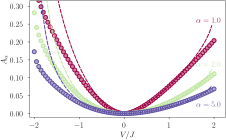

In [25]:
ias = [0,1,4]
αs =  [1,2,5]

fig, ax = plt.subplots() 
colors = colortools.get_linear_colors('Spectral',4,reverse=False)  
colors = [colors[0],colors[2],colors[-1]]

for col,(i,ia),α in zip(colors,enumerate(ias),αs): 
    # ED & DMRG scaling
    props_ED = {'ls':'None','ms':4,'marker':"o", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    ax.plot(V_array,Sinf[:,ia],**props_ED) 
    # LL
    props_LL = {'ls':'None','ms':4,'ls': '--', "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    filename = f'../data/eq_LL/entropiesLL_a{α}_LL_tdlimit_eps{ϵ}.npz' 
    loaded = np.load(filename)
    ax.plot(loaded['V'],loaded['A'],**props_LL) 
    # labels
    if α in  αs:
        offset = {2: 0.02, 1: 0.05,5: -0.05}
        ax.text(1.6,Sinf[-1,ia]+offset[α],f"$\\alpha={α:1.1f}$",color=col)
 
ax.set_ylim(-0.01,0.315)
ax.set_xlim(-2.1,2.25) 
ax.set_ylabel("$A_{{\\alpha}}$")
ax.set_xlabel("$V/J$")


figname = '007_equilibrium_tdLimit_pow1'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 8: Effective interaction cutoff in the equilibrium case

Load LL result

In [14]:
filename = '../data/eq_LL/cutoff_optimization.npz'
A_1 = Sinf[:,0]
 
loaded = np.load(filename,allow_pickle=True)
V_o = loaded['V']
ϵ_opt = loaded['eps'] 
 
V_fit = []
ϵ_fit = []
for v, optref in zip(V_o,ϵ_opt): 
    if isinstance(optref,OptimizeResult):
        V_fit.append(v)
        ϵ_fit.append(optref.x)
V_fit = np.array(V_fit)
ϵ_fit = np.array(ϵ_fit)

Plot

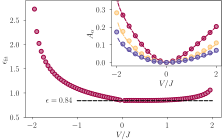

In [15]:
fig, ax = plt.subplots() 
colors = colortools.get_linear_colors('Spectral',1,reverse=False)  
col = colors[0]

props  = {'ls':'None','ms':4,'marker':"o", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
ax.plot(V_fit,ϵ_fit,**props)
ax.plot([-1,2],[ϵ,ϵ],'k--')
ax.set_ylim([0.5,2.9])
ax.text(-1.7,ϵ-0.04,f"$\\epsilon={ϵ:1.2f}$")
ax.set_ylabel("$\epsilon_{\\rm fit}$")
ax.set_xlabel("$V/J$")

# inset axis
in_ax = inset_axes(ax, width="56%", height="56%", loc='upper right', borderpad=0,
                       axes_kwargs=dict(fc='white'))  # x_start , y_start , height , width

_ias = [0,1,4]
_αs = [1,2,5]
_colors = colortools.get_linear_colors('Spectral',10*len(_ias),reverse=False)  
_colors = np.concatenate([_colors[::10][:-1],[_colors[-1]]])

for col,(i,ia),α in zip(_colors,enumerate(_ias),_αs): 
    # ED & DMRG scaling
    props_ED = {'ls':'None','ms':4,'marker':"o", "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    in_ax.plot(V_array[::5],Sinf[::5,ia],**props_ED) 
    # LL
    props_LL = {'ls':'None','ms':4,'ls': '--', "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    filename = f'../data/eq_LL/entropiesLL_a{α}_LL_tdlimit_eps_optS1.npz' 
    loaded = np.load(filename)
    in_ax.plot(loaded['V'],loaded['A'],**props_LL) 

in_ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.1f}"))
in_ax.set_ylim(-0.02,0.35)
in_ax.set_ylabel("$A_\\alpha$")
in_ax.set_xlabel("$V/J$")

figname = '008_fittedCutoff'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 9: Post quench LL steady state limit

Load LL data and finite size scale plateaus

In [ ]:
ϵ = 0.84

# Plateau scaling
Vs = np.arange(-2,2,0.1)
A1_inf = np.zeros(np.shape(Vs))
for iV, v in enumerate(Vs):
    filename = f'../data/quench_LL/LL_time_V{v:4.3f}_L_series_Lst6_Lend54_plateaus_eps{ϵ:4.3f}.npz'
    loaded = np.load(filename)
    N_ar_LL = loaded["L_array"]/2
    A1 = loaded["A"]

    γ = LL_utils.γ_V(v) 
 
    # perform fit a*x+Sinf 
    a, A1_inf[iV] = analyze_data_utils.fit_tail_linear(1/N_ar_LL,A1,npoints=3)


# Plateau values
Vs = np.arange(-2.0,2.0,0.1)
αs = [1] 
imap = {0:0}
A_i_LL = [[] for _ in αs]
γ_LL = [[] for _ in αs]
V_LL= [[] for _ in αs]

# A_i_LL[i] with i = 0 negativity, and α = i otherwise
for i, α in enumerate(αs):
    filename = f'../data/quench_LL/entropiesLL_a{α}_LL_tdlimit_tinf_eps{ϵ}_pow1.npz' 

    loaded = np.load(filename)
    γ_LL[i] = loaded['gamma']
    A_i_LL[i] = loaded['A']
    V_LL[i] = loaded['V']

Plot data

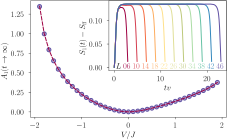

In [113]:
v = 1.0
ϵ = 0.84

Vs = np.arange(-2.0, 2.0, 0.1)

colors = colortools.get_linear_colors('Spectral', 2, reverse=False)

fig, ax = plt.subplots()


props_ED = {'ls': 'None', 'marker': "o", "color": colors[1],
            'mfc': colortools.get_alpha_hex(colors[1], 0.5)}
ax.plot(Vs, A1_inf, ms=4, label="LL plateau scaling", **props_ED)

ax.plot(V_LL[0], A_i_LL[0], '--', label="LL staedy state", color=colors[0])

ax.set_xlabel("$V/J$")
ax.set_ylabel("$A_1(t\\rightarrow\infty)$") 


ax = inset_axes(ax, width="60%", height="60%", loc='upper right', borderpad=0,
                axes_kwargs=dict(fc='white'))  # x_start , y_start , height , width


L_array = np.arange(6, 50, 4)

colors = colortools.get_linear_colors('Spectral', len(L_array), reverse=False)
colors[5] = "#e0df99"
colors[6] = "#bdc97b"

for iL, (L, col) in enumerate(zip(L_array, colors)):

    filename = f'../data/quench_LL/LL_time_V{v:4.3f}_Lseries_L{L:02d}_eps{ϵ:4.3f}.npz'
    loaded = np.load(filename)
    tres = loaded["tres"]
    A1 = loaded["A"]

    ax.plot(tres, A1, label=f"$\\bar{{L}}={L}$", color=col)
    ax.text(tres[-1]-1, A1[-1]-0.015, f"${L:02d}$", color=col)
ax.set_ylabel("$S_1(t)-S_{\\rm ff}$")
ax.set_xlabel("$tv $")
ax.text(0.35, A1[-1]-0.015, f"$L$", color="black") 


figname = f'009_quench_LL_plateau_scaling'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg', dpi=400)


### Figure 10: Evolution of one-particle entanglement after the quench

Load ED data

In [ ]:
data_folder = "../data/quench_ED/"

V_array_quench = np.arange(-1.9,1.95,0.1)
N_array_EDquench = np.arange(2,13,1)

i_N = lambda n: n-N_array_EDquench[0]

# load
quench_N = []
for N in N_array_EDquench:
    quench_N.append(load_data_utils.load_quench_data(N,V_array_quench, folder=data_folder))
# estimate t->inf limit
for n in N_array_EDquench:
    quench_N[i_N(n)] = analyze_data_utils.estimate_tinf_limit_all(quench_N[i_N(n)],n)
# estimate TD limit
V_quench, Sinf_quench, Serr_quench = analyze_data_utils.estimate_tinf_tdlimit_all(quench_N,N_array_EDquench,fit_npoints=5)

Plot time evolution

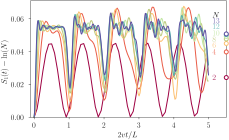

In [19]:
Ns = [2,4,6,8,10,12]
v = -0.5

fig, ax = plt.subplots()
colors = colortools.get_linear_colors('Spectral',len(Ns)+1,reverse=False)
colors[3]="#bdc97b"
for col, N in zip(colors,Ns):
    quench = quench_N[i_N(N)]
    ax.plot(quench.tres(v)[quench.tres(v)/N<5]/N, np.transpose(quench("S",i=1,V=v))[quench.tres(v)/N<5],label=f"$N={N}$",color=col) 
    _Sinf,_Serr = analyze_data_utils.intinite_t_entropy_and_error_sum(quench.t,quench("S",i=1,V=v),N,v,quench.Δt)
    ax.errorbar([5.5],[_Sinf],[_Serr],marker="o",mfc="white" ,mec=col,mew=1.0, ecolor=col, elinewidth=1.0,ms=4,clip_on=False,zorder=10)
    offset = {2:0,3:0,4:0,5:0,6:-0.001,7:0,8:-0.0002,9:0,10:0.002,11:0.002,12:0.005}
    ax.text(5.1,_Sinf-0.0015+offset[N],f"${N}$",color=col)
    
# add ED N=13
col = colors[-1]
N = 13
data = np.loadtxt("../data/quench_ED/particle_entanglement_n01_M26_N13_t+1.000_Vp+0.000_Vp0+0.000_V-0.500_V0+0.000_dt0.1000_tstart00.000_tendf_100.000.dat",encoding="utf-8")
quench_13 = load_data_utils.QuenchParticleEE([data],[v])
quench = analyze_data_utils.estimate_tinf_limit_all(quench_13,N=N)
ax.plot(quench.tres(v)[quench.tres(v)/N<5]/N, np.transpose(quench("S",i=1,V=v))[quench.tres(v)/N<5],label=f"$N={N}$",color=col) 
_Sinf,_Serr = analyze_data_utils.intinite_t_entropy_and_error_sum(quench.t,quench("S",i=1,V=v),N,v,quench.Δt)
ax.errorbar([5.5],[_Sinf],[_Serr],marker="o",mfc="white" ,mec=col,mew=1.0, ecolor=col, elinewidth=1.0,ms=4,clip_on=False,zorder=10)
offset = {13:0.008}
ax.text(5.1,_Sinf-0.0015+offset[N],f"${N}$",color=col)
   

ax.text(5.1,_Sinf+0.01,"$N$",color="black")
ax.set_xlim([-0.1,5.5]) 
ax.set_ylabel("$S_1(t)-\\ln(N)$")
ax.set_xlabel("$2v t/L$") 
ax.set_ylim(0,0.071) 

figname = f'010_quench_timedependenceS1_N'  
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 11: Finite size scaling of the steady state one-particle von Neumann entanglement entropy after the quench

0.10930005941419352
Warning for V=-1.3, iR=0 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=1 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=2 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=3 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=4 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=5 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=6 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=7 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=8 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=9 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=10 error estimation failed.  Use fallback method.


c:\Users\mtham\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mtham\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\mtham\anaconda3\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mtham\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\mtham\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\mtham\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return

Warning for V=-1.3, iR=0 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=1 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=2 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=3 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=4 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=5 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=6 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=7 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=8 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=9 error estimation failed.  Use fallback method.
Warning for V=-1.3, iR=10 error estimation failed.  Use fallback method.
Warning for V=-1.7, iR=0 error estimation failed.  Use fallback method.
Warning for V=-1.7, iR=1 error estimation failed.  Use fallback method.
Warning for V=-1.7, iR=2 error estimation failed.  Use fallback

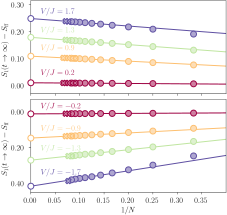

In [20]:
dmrg_data_N_lookup =  {0.2: [11,12,13,14,15], -0.2: [13,14], 0.9: [11,12,13,14,15], -0.9: [12,13,14], 1.3: [13,14], 1.7: [13,14] , -1.3:[12,13], -1.7: [13]}

dV = 0.05
V_array = np.arange(-2.0, 2.0+dV/2, dV)

Vs = [0.2,0.9,1.3,1.7]
Vinds = [np.argmin(np.abs(V_array-v)) for v in Vs]

#fig, axs = plt.subplots(1,2)
fig, axs = plt.subplots(2,1,figsize=(3.4039, 1.65*2.10373))
ax_f = axs.flatten()
colors = colortools.get_linear_colors('Spectral',len(Vs),reverse=False) 

N_array_fit = N_array_EDquench
 

ax = ax_f[0]
for col,v, vind in zip(colors,Vs,Vinds):
    γ = LL_utils.γ_V(v)

    # ED
    props_ED = {'ls':'None','ms':6,'marker':"o", "color": col,
             'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0,
             'mfc':colortools.get_alpha_hex(col,0.5)}  
    SinfN = np.array([quench("S",i=1,t=[-1],V=v)[0] for quench in quench_N])
    SinfN_fit = SinfN
    SerrN = np.array([quench("Serr",i=1,V=v) for quench in quench_N])
    SerrN_fit = SerrN
    N_array_fit = N_array_EDquench
    ax.errorbar(1/N_array_EDquench,SinfN,SerrN,**props_ED) 

    if v in dmrg_data_N_lookup.keys():
        Ns = dmrg_data_N_lookup[v]
        # load ITensorGPU data  
        props_DMRG = {'ls':'None','ms':5.5,'marker':"X", "color": col,
                    'mec':col,'mew':1.0, 'ecolor': col, 'elinewidth':1.0,
                    'mfc':colortools.get_alpha_hex(col,0.5)}  
        for nn in Ns:
            quench_DMRG = load_data_utils.load_itensor_quench_data(nn,tend=40,tstep=0.01,Vsta=v,Vend=v,Vnum=1,folder="../data/quench_dmrg") 
            quench_DMRG  = analyze_data_utils.estimate_tinf_limit_all(quench_DMRG ,nn)
            ax.errorbar(1/nn,quench_DMRG("S",i=1,t=[-1],V=v)[0],quench_DMRG("Serr",i=1,V=v),**props_DMRG) 

            if not (nn in N_array_fit): 
                N_array_fit = np.concatenate([N_array_fit,[nn]])
                SinfN_fit  = np.concatenate([SinfN_fit,[quench_DMRG("S",i=1,t=[-1],V=v)[0]]])
                SerrN_fit = np.concatenate([SerrN_fit,[quench_DMRG("Serr",i=1,V=v)]])
    
    # perform fit a*x+Sinf  
    a, S_tdlimit, S_tdlimit_err = analyze_data_utils.fit_tail_linear(1/N_array_fit,SinfN_fit,npoints=6,std_err=SerrN_fit)
    if v == 0.9:
        print(S_tdlimit)
    # plot fit
    x = np.arange(0,1,0.01)
    f = a*x+S_tdlimit
    ax.plot(x,f,color=col)
    ax.errorbar([0],[S_tdlimit],[S_tdlimit_err],marker="o",**{ 'mfc': "white",'ls':'None','ms':6,"zorder":10,'color':col,'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0},clip_on=False)

    ax.text(0.02,quench_N[-1]("S",i=1,t=[-1],V=v)[0]+0.03,f"$V/J={v:1.1f}$",color=col)
 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.2f}"))
ax.set_ylim(-0.03,0.315)
ax.set_xlim(0,.3999) 
ax.set_ylabel("$S_1(t\\rightarrow\infty)-S_{\\rm ff}$") 
ax.set_xticklabels("") 


# negative V

ax = ax_f[1]

Vs = [-0.2,-0.9,-1.3,-1.7]
Vinds = [np.argmin(np.abs(V_array-v)) for v in Vs] 
colors = colortools.get_linear_colors('Spectral',len(Vs),reverse=False) 
N_array_fit = N_array_EDquench

for col,v, vind in zip(colors,Vs,Vinds):
    γ = LL_utils.γ_V(v)

    # ED
    props_ED = {'ls':'None','ms':6,'marker':"o", "color": col,
             'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0,
             'mfc':colortools.get_alpha_hex(col,0.5)}  
    SinfN = np.array([quench("S",i=1,t=[-1],V=v)[0] for quench in quench_N])
    SinfN_fit = SinfN
    SerrN = np.array([quench("Serr",i=1,V=v) for quench in quench_N])
    SerrN_fit = SerrN
    N_array_fit = N_array_EDquench
    ax.errorbar(1/N_array_EDquench,SinfN,SerrN,**props_ED) 

    if v in dmrg_data_N_lookup.keys():
        Ns = dmrg_data_N_lookup[v]
        # load ITensorGPU data  
        props_DMRG = {'ls':'None','ms':5.5,'marker':"X", "color": col,
                    'mec':col,'mew':1.0, 'ecolor': col, 'elinewidth':1.0,
                    'mfc':colortools.get_alpha_hex(col,0.5)}  
        for nn in Ns:
            quench_DMRG = load_data_utils.load_itensor_quench_data(nn,tend=40,tstep=0.01,Vsta=v,Vend=v,Vnum=1,folder="../data/quench_dmrg") 
            quench_DMRG  = analyze_data_utils.estimate_tinf_limit_all(quench_DMRG ,nn)
            ax.errorbar(1/nn,quench_DMRG("S",i=1,t=[-1],V=v)[0],quench_DMRG("Serr",i=1,V=v),**props_DMRG) 

            if not (nn in N_array_fit):
                N_array_fit = np.concatenate([N_array_fit,[nn]])
                SinfN_fit  = np.concatenate([SinfN_fit,[quench_DMRG("S",i=1,t=[-1],V=v)[0]]])
                SerrN_fit = np.concatenate([SerrN_fit,[quench_DMRG("Serr",i=1,V=v)]]) 
    # perform fit a*x+Sinf   
    a, S_tdlimit, S_tdlimit_err = analyze_data_utils.fit_tail_linear(1/N_array_fit,SinfN_fit,npoints=6,std_err=SerrN_fit)
    # plot fit
    x = np.arange(0,1,0.01)
    f = a*x+S_tdlimit
    ax.plot(x,f,color=col)
    ax.errorbar([0],[S_tdlimit],[S_tdlimit_err],marker="o",**{ 'mfc': "white",'ls':'None','ms':6,"zorder":10,'color':col,'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0},clip_on=False)
 


    ax.text(0.02,quench_N[-1]("S",i=1,t=[-1],V=v)[0]-0.03,f"$V/J={v:1.1f}$",color=col) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.2f}"))
ax.set_ylim(-0.07,0.45)
ax.set_xlim(0,0.3999) 
ax.set_ylabel("$S_1(t\\rightarrow\infty)-S_{\\rm ff}$")
ax.set_xlabel("$1/N$")
ax.invert_yaxis()
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 

plt.subplots_adjust(hspace=0.06)

figname = '011_quench_finiteSizeScaling_V_pow1'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 12: Comparing numerical steady state one-particle entanglement to LL result in the thermodynamic limit after a quench

Load data

In [ ]:
#ED
data_folder = "../data/quench_ED/"

V_array_quench = np.arange(-1.9,1.95,0.1)
N_array_EDquench = np.arange(2,13,1)

i_N = lambda n: n-N_array_EDquench[0]

# load
quench_N = []
for N in N_array_EDquench:
    quench_N.append(load_data_utils.load_quench_data(N,V_array_quench, folder=data_folder))
# estimate t->inf limit
for n in N_array_EDquench:
    quench_N[i_N(n)] = analyze_data_utils.estimate_tinf_limit_all(quench_N[i_N(n)],n)
# estimate TD limit
V_quench, Sinf_quench, Serr_quench = analyze_data_utils.estimate_tinf_tdlimit_all(quench_N,N_array_EDquench,fit_npoints=5)


dmrg_data_N_lookup =  {0.2: [11,12,13,14,15], -0.2: [13,14], 0.9: [11,12,13,14,15], -0.9: [12,13,14], 1.3: [13,14], 1.7: [13,14] , -1.3:[12,13], -1.7: [13]}

for i in range(1,12):
    for v in dmrg_data_N_lookup.keys():
        # ED Data
        N_array_fit = N_array_EDquench
        SinfN_fit = np.array([quench("S",i=i,t=[-1],V=v)[0] for quench in quench_N]) 
        SerrN_fit = np.array([quench("Serr",i=i,V=v) for quench in quench_N]) 
        iv = np.where(np.abs(V_quench-v)<1e-8)[0][0]
        # DMRG Data
        for nn in dmrg_data_N_lookup[v]:
            quench_DMRG = load_data_utils.load_itensor_quench_data(nn,tend=40,tstep=0.01,Vsta=v,Vend=v,Vnum=1,folder="../data/quench_dmrg") 
            quench_DMRG  = analyze_data_utils.estimate_tinf_limit_all(quench_DMRG ,nn) 
            if not nn in N_array_fit:
                    N_array_fit = np.concatenate([N_array_fit,[nn]])
                    SinfN_fit  = np.concatenate([SinfN_fit,[quench_DMRG("S",i=i,t=[-1],V=v)[0]]])
                    SerrN_fit = np.concatenate([SerrN_fit,[quench_DMRG("Serr",i=i,V=v)]])
        a, S_tdlimit, S_tdlimit_err = analyze_data_utils.fit_tail_linear(1/N_array_fit,SinfN_fit,npoints=6,std_err=SerrN_fit)

        Sinf_quench[i-1,[iv]] = S_tdlimit
        Serr_quench[i-1,[iv]] = S_tdlimit_err

Plot

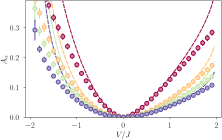

In [22]:
ias = [0,1,2,4]
αs = [1,2,3,5]

ϵ = 0.84

fig, ax = plt.subplots() 
colors = colortools.get_linear_colors('Spectral',len(ias),reverse=False)  

for col,(i,ia),α in zip(colors,enumerate(ias),αs): 
    # ED  
    props_ED = {'ls':'None','ms':4,'marker':"o", "color": col,
             'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    ax.errorbar(V_quench, Sinf_quench[ia,:], Serr_quench[ia,:],**props_ED) 
    # LL
    props_LL = {'ls':'None','ms':4,'ls': '--', "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    filename = f'../data/quench_LL/entropiesLL_quench_a{α}_LL_tdlimit_eps{ϵ}.npz' 
    loaded = np.load(filename)
    ax.plot(loaded['V'],loaded['A'],**props_LL) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.1f}"))
ax.set_ylim(0,0.39)
ax.set_xlim(-2.1,2.1) 
ax.set_ylabel("$A_\\alpha$")
ax.set_xlabel("$V/J$")


figname = '012_quench_tdLimit_pow1'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 13: Interaction dependence of the effective cutoff

Load fit result and LL result

In [23]:
# equilibrium
filename = '../data/eq_LL/cutoff_optimization.npz'
 
loaded = np.load(filename,allow_pickle=True)
V_o = loaded['V']
ϵ_opt = loaded['eps'] 
 
V_fit = []
ϵ_fit = []
for v, optref in zip(V_o,ϵ_opt): 
    if isinstance(optref,OptimizeResult):
        V_fit.append(v)
        ϵ_fit.append(optref.x)
V_fit = np.array(V_fit)
ϵ_fit = np.array(ϵ_fit)

# quench
filename = '../data/quench_LL/cutoff_optimization_quench.npz'

loaded = np.load(filename,allow_pickle=True)
V_o = loaded['V']
ϵ_opt = loaded['eps']  

V_fit_quench = []
ϵ_fit_quench = []
for v, optref in zip(V_o,ϵ_opt): 
    if isinstance(optref,OptimizeResult):
        V_fit_quench.append(v)
        ϵ_fit_quench.append(optref.x)
V_fit_quench = np.array(V_fit_quench)
ϵ_fit_quench = np.array(ϵ_fit_quench)

Plot

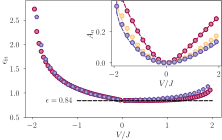

In [24]:
fig, ax = plt.subplots() 
colors = colortools.get_linear_colors('Spectral',2,reverse=False)   

# eq
props  = {'ls':'None','ms':4,'marker':"o", "color": colors[0],
             'mfc':colortools.get_alpha_hex(colors[0],0.5)} 
ax.plot(V_fit,ϵ_fit,**props)  
# quench
props  = {'ls':'None','ms':4,'marker':"p", "color": colors[1],
             'mfc':colortools.get_alpha_hex(colors[1],0.5)} 
ax.plot(V_fit_quench,ϵ_fit_quench,**props)    

ax.plot([-1,2],[ϵ,ϵ],'k--')
ax.set_ylim([0.5,2.9])
ax.text(-1.7,ϵ-0.04,f"$\\epsilon={ϵ:1.2f}$")
ax.set_ylabel("$\epsilon_{\\rm fit}$")
ax.set_xlabel("$V/J$")

# inset axis
in_ax = inset_axes(ax, width="56%", height="56%", loc='upper right', borderpad=0,
                       axes_kwargs=dict(fc='white'))  # x_start , y_start , height , width

_ias = [0,1,2]
_αs = [1,2,3]
_colors = colortools.get_linear_colors('Spectral',10*len(_ias),reverse=False)  
_colors = np.concatenate([_colors[::10][:-1],[_colors[-1]]])

for col,(i,ia),α in zip(_colors,enumerate(_ias),_αs): 
    # ED scaling
    props_ED = {'ls':'None','ms':4,'marker':"o", "color": col,
             'mec':col,'mew':1.0, 'ecolor':col, 'elinewidth':1.0,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    in_ax.errorbar(V_quench[::2], Sinf_quench[ia,::2], Serr_quench[ia,::2],**props_ED) 
    # LL
    props_LL = {'ls':'None','ms':4,'ls': '--', "color": col,
             'mfc':colortools.get_alpha_hex(col,0.5)} 
    filename = f'../data/quench_LL/entropiesLL_quench_a{α}_LL_tdlimit_eps_optS1.npz' 
    loaded = np.load(filename)
    in_ax.plot(loaded['V'],loaded['A'],**props_LL) 

in_ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:1.1f}"))
in_ax.set_ylim(-0.02,0.399)
# in_ax.set_xlim(0,0.15) 
in_ax.set_ylabel("$A_\\alpha$")
in_ax.set_xlabel("$V/J$")

figname = '013_fittedCutoff_quench_pow1'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400)

### Figure 14: Time evolution of distribution function

load data

In [48]:
V = [-6.5, -1.8, -0.5, 1.5]
Vnum = len(V)
N = 12
L = 2*N
obdmh = np.zeros([Vnum, L, 1001])
index = np.zeros([L])
for Vi in range(Vnum):
    if V[Vi] >= 0:
        Vname = '+'+f'{V[Vi]:5.3f}'
    else:
        Vname = f'{V[Vi]:5.3f}'
    FileName = f'../data/obdm/obdms_N{N:02d}/obdm_{L:02d}_{N:02d}_' + \
        Vname+'_+0.000_tstart+0.000_tend+100.000_tstep+0.100.dat'
    data = np.loadtxt(FileName)
    index[0:N+1] = data[N-1::, 0]
    index[N+1:] = data[0:N-1, 0]
    obdmh[Vi, 0:N+1, :] = data[N-1::, 1:]
    obdmh[Vi, N+1::, :] = (-1)**(N % 2-1)*data[0:N-1, 1:]

TP = len(obdmh[0, 0, :])
obdmT = np.zeros([Vnum, TP, L])
for Vi in range(Vnum):
    obdmh[Vi, :, :] = analyze_data_utils.obdbs(obdmh[Vi, :, :], N, L)
    obdmT[Vi, :, :] = N*np.transpose(obdmh[Vi, :, :])

# q values
q = np.zeros(L+1)
for qi in range(0, L+1):
    q[qi] = (2*qi-2*N+(1-N % 2))*π/L
Δ = (q[1]-q[0])/2
for qi in range(0, L+1):
    q[qi] = q[qi]-Δ
# t values
t = np.zeros(TP)
for ti in range(0, TP):
    t[ti] = ti*0.1


calculate spectra and return transpose

In [80]:
fig, ax = plt.subplots(1,4,figsize=(2*plt.rcParams["figure.figsize"][0],plt.rcParams["figure.figsize"][1]))
tsart=0
tend=400
obdmp=np.ones([tend-tsart,L+1])
for Vi in range(Vnum):
    obdmp[:,:-1]=(abs(obdmT[Vi,tsart:tend,:]))
    df_norm_col=obdmp
    im=ax[Vi].pcolor(q,t[tsart:tend],df_norm_col, cmap='RdBu',vmin=0, vmax=.9999)
    if (Vi==1)|(Vi==0):
        txtcolor="black"
    else:
        txtcolor="yellow"
    ax[Vi].text(0,35.5, f'$V/J= {V[Vi]:5.1f}$',   color=txtcolor, ha="center", fontsize=9)

    ax[0].yaxis.set_ticks(np.arange(0, 40, 5))
    ax[0].axvline(x=q[int(3*N/2)],linestyle='--',linewidth=.8,color="#888888")
    ax[0].axvline(x=q[int(N/2)],linestyle='--',linewidth=.8,color="#888888")
    if Vi==0: 
        ax[Vi].set_ylabel('$t$')
        ax[Vi].axvline(x=q[int(3*N/2)],linestyle='--',linewidth=.8,color="#888888")
        ax[Vi].axvline(x=q[int(N/2)],linestyle='--',linewidth=.8,color="#888888")
        ax[Vi].text(q[int(3*N/2)-1]*1.0, 1.8, '$k_F$', fontsize=9)
        ax[Vi].text(q[int(N/2)-2]*1.1, 1.8, '$-k_F$', fontsize=9)
    else: 
        ax[Vi].yaxis.set_ticklabels([])#.set_tick_params(axis='y', labelleft="off", labelright="off")
    ax[Vi].set_xlabel('$q$')
    ax[Vi].set_xticks([-2,0,2])
    ax[Vi].set_xlim(-np.pi,np.pi-1/12)


# Adjust space between subplots
plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace = 0.035)

colorbar_ax = fig.add_axes([0.96, 0.15, 0.025, .768])
fig.colorbar(im, cax=colorbar_ax,label='$N\\rho_1(q,t)$')

plt.subplots_adjust(wspace=0.04)

figname = '014_obdmTimeEvolution'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400) 

### Figure 15: Comparison time average of distribution function and equilibrium case

Load obdm data

In [34]:
V = [-1.8]
Vnum = len(V)
N = 12
L = 2*N
obdm = np.zeros([Vnum, L, 1001])
obdmEq = np.zeros([Vnum, L, 1])


for Vi in range(Vnum):
    if V[Vi] >= 0:
        Vname = '+'+f'{V[Vi]:5.3f}'
    else:
        Vname = f'{V[Vi]:5.3f}'
    FileName = f'../data/obdm/obdms_N{N:02d}/obdm_{L:02d}_{N:02d}_' + \
        Vname+'_+0.000_tstart+0.000_tend+100.000_tstep+0.100.dat'
    data = np.loadtxt(FileName)
    """
    Adjust the data such that it represents the first raw of the obdm
    and takes into account the proper boundary conditions    
    """
    obdm[Vi, 0:N+1, :] = data[N-1::, 1:]
    obdm[Vi, N+1::, :] = (-1)**(N % 2-1)*data[0:N-1, 1:]
    FileName = f'../data/obdm/obdm_{L:02d}_{N:02d}_'+Vname+'_+0.000.dat'
    data = np.loadtxt(FileName)

    obdmEq[Vi, 0:N+1] = data[N-1::, 1:]
    obdmEq[Vi, N+1::] = (-1)**(N % 2-1)*data[0:N-1, 1:]


time-average of the spectra and its std σ

In [35]:
# λEq its std σEq
λ = np.zeros([Vnum, L])
λEq = np.zeros([Vnum, L])
σ = np.zeros([Vnum, L])
σEq = np.zeros([Vnum, L])
for Vi in range(Vnum):
    obdm[Vi, :, :] = analyze_data_utils.obdbs(obdm[Vi, :, :], N, L)
    λ[Vi, :], σ[Vi, :] = analyze_data_utils.spectra(obdm[Vi, :, :])
    λEq[Vi, :] = analyze_data_utils.obdbs(obdmEq[Vi, :, :], N, L)[:, 0]

# q values
q = np.zeros(L)
for qi in range(0, L):
    q[qi] = (qi-N+(1-N % 2)/2)*2*π/L


plot

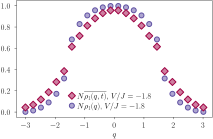

In [37]:
colors = colortools.get_linear_colors('Spectral',2)

fig = plt.figure()
ax = fig.add_subplot(111)
#ax1 = fig.add_subplot(111)
ax.set_xlabel(r'$q$')
col = colors[0] 
ax.plot(q, λ[0, :]*N, 'D', markerfacecolor = colortools.get_alpha_hex(col, 0.5), lw=3,
        markeredgecolor=col, label=f'$N\\overline{{\\rho_1(q,t)}},$ $V/J={V[0]:3.1f}$')
col = colors[1] 
ax.plot(q, λEq[0, :]*N, 'o', lw=3, markerfacecolor = colortools.get_alpha_hex(col, 0.5), 
        label=f'$N\\rho_1(q)$, $V/J={V[0]:3.1f}$', zorder=0,markeredgecolor=col)

lgnd1 = plt.legend(loc=(.250, 0.03),handlelength=.8,
                   title=None, frameon=False, handletextpad=.25)
 
figname = '015_time_average_obdm'
plt.savefig(f'../figures/{figname}.pdf')
plt.savefig(f'../figures/{figname}.svg',dpi=400) 
